In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
from PIL import Image, ImageDraw, ImageFont

font_path = '../dados/targa/Targa.ttf'

In [3]:
import tensorflow as tf

2024-08-02 10:10:41.930779: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [4]:
!wget  -nc https://www.dropbox.com/scl/fi/uaiyxp0t2l8hfcszfadtj/dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius&dl=1
!unzip -n -q dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius, dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.zip or dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.ZIP.

No zipfiles found.


In [5]:
image_path = '../dados/CAPTCHA-10k/treinamento'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,000001.jpg,RNINIC
1,000002.jpg,TVCFS8
2,000003.jpg,N1O1EH
3,000004.jpg,OQZSL4
4,000005.jpg,GST2YA


In [6]:
vocab = [ '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ']']
num_classes = len(vocab)
char_to_index = {char: idx for idx, char in enumerate(vocab)}

In [7]:
tf.constant(vocab)[0]

2024-08-02 10:10:44.371151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13819 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


<tf.Tensor: shape=(), dtype=string, numpy=b'0'>

In [8]:
def generate_clean_captcha(text):
    # Fixed parameters
    size = (180, 50)  # Change size to (height, width)
    font_size = 24
    num_parts = 6

    # Create a blank white image
    image = Image.new('L', size, 255)  # 'L' mode for grayscale

    # Load the custom font
    font = ImageFont.truetype(font_path, font_size)

    # Create a drawing context
    draw = ImageDraw.Draw(image)

    # Calculate positions for each part
    part_width = size[0] / num_parts
    horizontal_positions = [int(part_width * i + part_width / 2) for i in range(num_parts)]
    horizontal_positions = horizontal_positions[:len(text)]  # Adjust to the length of the text

    # Calculate y position to center the text vertically
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_height = text_bbox[3] - text_bbox[1]
    text_y = (size[1] - text_height) // 2

    # Draw each letter at the calculated position
    for char, x in zip(text, horizontal_positions):
        char_bbox = draw.textbbox((0, 0), char, font=font)
        char_width = char_bbox[2] - char_bbox[0]
        char_x = x - char_width // 2  # Center the character horizontally within its part
        draw.text((char_x, text_y), char, font=font, fill=0)

    # Convert to numpy array if needed for further processing with OpenCV
    captcha_image = np.array(image)

    return captcha_image

In [9]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [10]:
def generate_X_Y(image_path):
  df = generate_df(image_path)
  df['txt_content'] = df['txt_content'].apply(lambda x: x + "]" if len(x) == 6 else x)

  X = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  X = np.array(X)
  X = np.expand_dims(X, axis=-1)

  Y = np.array([generate_clean_captcha(x) for x in df["txt_content"]])
  X = X.astype('float32') / 255.
  Y = (Y.astype('float32') - 127.5)  / 127.5
  
  return X,Y,df['txt_content']

X_train, Y_train,labels_train = generate_X_Y('../dados/CAPTCHA-10k/treinamento')
X_val, Y_val,labels_val = generate_X_Y('../dados/CAPTCHA-10k/validacao')

In [11]:
def build_dataset(X,predictions, labels, batch_size=32):
    def encode_labels(labels):
        # Create an array to store one-hot encoded labels
        encoded_labels = np.zeros((len(labels), 7, num_classes), dtype=np.float32)
        
        for i, label in enumerate(labels):
            for j, char in enumerate(label):
                index = char_to_index.get(char, -1)
                encoded_labels[i, j, index] = 1.0
        return encoded_labels
    
    Y = encode_labels(labels)
    
    # Create TensorFlow datasets from X and Y
    dataset = tf.data.Dataset.from_tensor_slices((X, predictions,Y))

    # Shuffle, batch, and prefetch the dataset
    buffer_size = len(X)  # Typically set to the size of the dataset
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset
train_dataset = build_dataset(X_train,Y_train, labels_train)
val_dataset = build_dataset(X_val,Y_val, labels_val)

In [12]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [13]:
autoencoder = tf.keras.models.load_model('model_MSE_aug_best_unet.tf',custom_objects={"rmse": rmse,"psnr":psnr})
classifier = tf.keras.models.load_model('classifier_pre_trained.tf')

In [14]:
a = autoencoder(X_train[:1])

2024-08-02 10:10:52.500788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-08-02 10:10:53.153247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


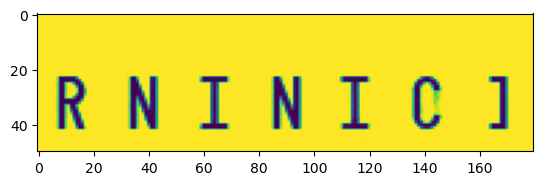

In [15]:
plt.imshow(a[0])

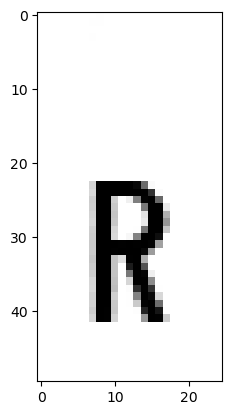

In [16]:
plt.imshow(a[0,:,0:25,:],cmap='grey')

In [17]:
vocab[np.argmax(classifier(a[:,:,0:25,:]))]

'R'

In [18]:
def classification_loss(y_true, y_pred):
    # Reshape y_true and y_pred to match the shape expected for loss calculation
    return tf.reduce_mean(tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred))

def reconstruction_loss(autoencoder_output, captcha_predictions):
    # Flatten the outputs and targets
    autoencoder_output_flat = tf.keras.backend.flatten(autoencoder_output)
    captcha_predictions_flat = tf.keras.backend.flatten(captcha_predictions)
    
    # Compute MSE loss
    return tf.reduce_mean(tf.square(autoencoder_output_flat - captcha_predictions_flat))

In [19]:
vocab_tensor = tf.constant(vocab)

In [23]:
import tensorflow_addons as tfa  # Import TensorFlow Addons

def random_rotate(image, max_angle=0.1):
    angle = tf.random.uniform([], -max_angle, max_angle)
    return tfa.image.rotate(image, angle)

def random_shift(image, width_shift_range=0.1, height_shift_range=0.05):
    width_shift = tf.random.uniform([], -width_shift_range, width_shift_range) * tf.cast(tf.shape(image)[1], tf.float32)
    height_shift = tf.random.uniform([], -height_shift_range, height_shift_range) * tf.cast(tf.shape(image)[0], tf.float32)
    return tfa.image.translate(image, [width_shift, height_shift])

def random_shear(image, shear_range=0.1):
    shear = tf.random.uniform([], -shear_range, shear_range)
    return tfa.image.transform(image, [1, shear, 0, shear, 1, 0, 0, 0])

def random_zoom(image, zoom_range=0.1):
    zoom_factor = tf.random.uniform([], 1 - zoom_range, 1 + zoom_range)
    return tfa.image.transform(image, [zoom_factor, 0, 0, 0, zoom_factor, 0, 0, 0])

In [24]:
LAMBDA = 10
@tf.function
def train_step(input_images, true_images, labels, autoencoder, classifier, optimizer):
    with tf.GradientTape() as tape:
        # Forward pass through the autoencoder
        autoencoder_output  = autoencoder(input_images, training=True)
        r_loss = reconstruction_loss(autoencoder_output, true_images)

        def augment_image(image):
            image = random_rotate(image)
            image = random_shift(image)
            image = random_shear(image)
            image = random_zoom(image)
            return image

        augmented_output = tf.map_fn(augment_image, autoencoder_output)

        predictions_list = []
        true_list = []

        c_loss = 0.0
        interval = [0, 25, 50, 75, 100, 125, 150, 175]

        for i in range(len(interval)-1):
            fake_img = augmented_output[:,:,interval[i]:interval[i+1],:]
            y_pred = classifier(fake_img, training=True)
            c_loss += classification_loss(labels[:,i], y_pred)
            predictions_list.append(y_pred)
            true_list.append(labels[:,i])

            # pred = vocab_tensor[tf.argmax(y_pred, axis=-1)[0]]
            # act = vocab_tensor[tf.argmax(labels[:, i], axis=-1)[0]]
            # tf.print("Pred", pred, "act", act, "c_l", c_loss)
        c_loss /= (len(interval) - 1)
        loss = r_loss + LAMBDA*c_loss
        
    # Compute gradients
    gradients = tape.gradient(loss, autoencoder.trainable_variables + classifier.trainable_variables)
    
    # Apply gradients
    optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables + classifier.trainable_variables))

    # Compute accuracy
    predictions = tf.concat(predictions_list, axis=0)  # Concatenate predictions from all patches
    predictions = tf.argmax(predictions, axis=-1)  # Convert to class indices
    predictions = tf.reshape(predictions, [-1])  # Flatten predictions

    true = tf.concat(true_list, axis=0)  # Concatenate true from all patches
    true = tf.argmax(true, axis=-1)  # Convert to class indices
    true = tf.reshape(true, [-1])  # Flatten true

    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, true), tf.float32))
    return loss, accuracy, r_loss, c_loss

In [25]:
@tf.function
def validation_step(input_images, true_images, labels, autoencoder, classifier):
    # Forward pass through the autoencoder
    autoencoder_output = autoencoder(input_images, training=False) # MAKE AUGMENTATION HERE 
    predictions_list = []
    true_list = []

    c_loss = 0.0
    interval = [0, 25, 50, 75, 100, 125, 150, 175]

    for i in range(len(interval) - 1):
        fake_img = autoencoder_output[:, :, interval[i]:interval[i + 1], :]
        y_pred = classifier(fake_img, training=False)
        c_loss += classification_loss(labels[:, i], y_pred)
        predictions_list.append(y_pred)
        true_list.append(labels[:, i])

    c_loss /= (len(interval) - 1)
    r_loss = reconstruction_loss(autoencoder_output, true_images)
    loss = r_loss + LAMBDA*c_loss

    # Compute accuracy
    predictions = tf.concat(predictions_list, axis=0)  # Concatenate predictions from all patches
    predictions = tf.argmax(predictions, axis=-1)  # Convert to class indices
    predictions = tf.reshape(predictions, [-1])  # Flatten predictions

    true = tf.concat(true_list, axis=0)  # Concatenate true from all patches
    true = tf.argmax(true, axis=-1)  # Convert to class indices
    true = tf.reshape(true, [-1])  # Flatten true

    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, true), tf.float32))
    return loss, accuracy, r_loss, c_loss


In [26]:
optimizer = tf.keras.optimizers.Adam()
checkpoint_dir = './checkpoints'
checkpoint = tf.train.Checkpoint(autoencoder=autoencoder, classifier=classifier, optimizer=optimizer)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
best_val_accuracy = 0.0


In [27]:
epochs = 100

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Initialize metrics to accumulate loss and accuracy for training
    train_epoch_loss = tf.keras.metrics.Mean()
    train_epoch_accuracy = tf.keras.metrics.Mean()
    train_epoch_r_loss = tf.keras.metrics.Mean()
    train_epoch_c_loss = tf.keras.metrics.Mean()

    # Training loop
    for (input_images, true_images, labels) in train_dataset:
        loss, acc, r_loss, c_loss = train_step(input_images, true_images, labels, autoencoder, classifier, optimizer)
        
        # Update metrics for training
        train_epoch_loss.update_state(loss)
        train_epoch_accuracy.update_state(acc)
        train_epoch_r_loss.update_state(r_loss)
        train_epoch_c_loss.update_state(c_loss)
    
    # Initialize metrics to accumulate loss and accuracy for validation
    val_epoch_loss = tf.keras.metrics.Mean()
    val_epoch_accuracy = tf.keras.metrics.Mean()
    val_epoch_r_loss = tf.keras.metrics.Mean()
    val_epoch_c_loss = tf.keras.metrics.Mean()

    # Validation loop
    for (input_images, true_images, labels) in val_dataset:
        val_loss, val_acc, val_r_loss, val_c_loss = validation_step(input_images, true_images, labels, autoencoder, classifier)
        
        # Update metrics for validation
        val_epoch_loss.update_state(val_loss)
        val_epoch_accuracy.update_state(val_acc)
        val_epoch_r_loss.update_state(val_r_loss)
        val_epoch_c_loss.update_state(val_c_loss)

    # Print the mean loss and accuracy for the epoch
    print(f"Training loss: {train_epoch_loss.result().numpy()}  acc: {train_epoch_accuracy.result().numpy()}")
    print(f"Reconstruction loss: {train_epoch_r_loss.result().numpy()}  Classification loss: {train_epoch_c_loss.result().numpy()}")
    print("*"*80)
    # Print the mean loss and accuracy for the validation set
    print(f"Validation loss: {val_epoch_loss.result().numpy()}  acc: {val_epoch_accuracy.result().numpy()}")
    print(f"Validation Reconstruction loss: {val_epoch_r_loss.result().numpy()}  Validation Classification loss: {val_epoch_c_loss.result().numpy()}\n")


    # Save the best model based on validation accuracy
    if val_epoch_accuracy.result().numpy() > best_val_accuracy:
        best_val_accuracy = val_epoch_accuracy.result().numpy()
        checkpoint_manager.save()
        print(f"Checkpoint saved at epoch {epoch+1} with validation accuracy: {best_val_accuracy}\n")

Epoch 1/100


2024-08-01 18:07:29.312162: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x8ac8b00
2024-08-01 18:07:29.691056: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x758242814190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-01 18:07:29.691092: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-08-01 18:07:29.695727: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-01 18:07:29.823168: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training loss: 38.0506477355957  acc: 0.32980355620384216
Reconstruction loss: 0.7602190971374512  Classification loss: 3.7290422916412354
********************************************************************************
Validation loss: 16.30363655090332  acc: 0.5502232313156128
Validation Reconstruction loss: 0.6764039397239685  Validation Classification loss: 1.5627232789993286

Checkpoint saved at epoch 1 with validation accuracy: 0.5502232313156128

Epoch 2/100
Training loss: 19.335723876953125  acc: 0.5284463167190552
Reconstruction loss: 0.712222158908844  Classification loss: 1.862350344657898
********************************************************************************
Validation loss: 12.987470626831055  acc: 0.6784319877624512
Validation Reconstruction loss: 0.7141578197479248  Validation Classification loss: 1.2273313999176025

Checkpoint saved at epoch 2 with validation accuracy: 0.6784319877624512

Epoch 3/100
Training loss: 16.43392562866211  acc: 0.6076071858406067
Re

In [ ]:
a = autoencoder(X_train[:1])
plt.imshow(a[0])

Error in callback <function flush_figures at 0x77e4b074f790> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 